In [1]:
import yfinance as yf
import pandas as pd
from polygon import RESTClient
from polygon.rest.models import (
    MarketHoliday,
)
import time
import numpy as np
from dateutil import parser
from datetime import datetime , timedelta
import os
import matplotlib.pyplot as plt
import pytz
from py_vollib_vectorized import price_dataframe, get_all_greeks
from py_vollib_vectorized.api import get_all_greeks
from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility, vectorized_implied_volatility_black

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
client = RESTClient(api_key="15guSuGaxfgXATkke4aFf1rQL6lxOtjL")

In [4]:
round_off = 5
df = yf.download('^GSPC', interval='1d', period='1y')
df.reset_index(inplace=True)
df['atm'] = df['Open'].apply(lambda x: round(x / round_off) * round_off)
df['ub'] = (df['Open'] * 1.01).apply(lambda x: round(x / round_off) * round_off)
df['lb'] = (df['Open'] * 0.99).apply(lambda x: round(x / round_off) * round_off)
df['factor'] = df['Close'].rolling(5).mean().shift(1)
df['signal'] = np.where(df['Open'] > df['factor'], 1,0)
df.dropna(inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,atm,ub,lb,factor,signal
5,2022-12-12,3939.290039,3990.709961,3935.300049,3990.560059,3990.560059,3904130000,3940,3980,3900,3954.381982,0
6,2022-12-13,4069.379883,4100.959961,3993.030029,4019.649902,4019.649902,5079360000,4070,4110,4030,3952.725977,1
7,2022-12-14,4015.540039,4053.760010,3965.649902,3995.320068,3995.320068,4472340000,4015,4055,3975,3968.403955,1
8,2022-12-15,3958.370117,3958.370117,3879.449951,3895.750000,3895.750000,4493900000,3960,4000,3920,3980.683984,0
9,2022-12-16,3890.909912,3890.909912,3827.909912,3852.360107,3852.360107,7493660000,3890,3930,3850,3967.131982,0
...,...,...,...,...,...,...,...,...,...,...,...,...
246,2023-11-28,4545.549805,4568.140137,4540.509766,4554.890137,4554.890137,3586240000,4545,4590,4500,4550.391992,0
247,2023-11-29,4571.839844,4587.640137,4547.149902,4550.580078,4550.580078,4418760000,4570,4620,4525,4551.894043,1
248,2023-11-30,4554.870117,4569.890137,4537.240234,4567.799805,4567.799805,5399300000,4555,4600,4510,4554.372070,1
249,2023-12-01,4559.430176,4599.390137,4554.709961,4594.629883,4594.629883,4397120000,4560,4605,4515,4556.608008,1


In [5]:
sofr = pd.read_csv('sofr_search.csv')
sofr = sofr[sofr['Rate Type'] == 'SOFR']
sofr.drop(['1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
       'Volume ($Billions)', 'Target Rate From (%)', 'Target Rate To (%)',
       'Intra Day - Low (%)', 'Intra Day - High (%)', 'Standard Deviation (%)',
       '30-Day Average SOFR', '90-Day Average SOFR', '180-Day Average SOFR',
       'SOFR Index', 'Revision Indicator (Y/N)', 'Footnote ID'], axis=1, inplace=True)
sofr['Date'] = pd.to_datetime(sofr['Date'])
sofr = sofr.sort_values(by='Date', ascending=True)
sofr

,Date,Rate Type,Rate (%)
1251,2022-12-01,SOFR,3.82
1246,2022-12-02,SOFR,3.81
1241,2022-12-05,SOFR,3.81
1236,2022-12-06,SOFR,3.80
1231,2022-12-07,SOFR,3.80
...,...,...,...
24,2023-11-24,SOFR,5.32
19,2023-11-27,SOFR,5.32
14,2023-11-28,SOFR,5.32
9,2023-11-29,SOFR,5.31


In [6]:
final_df = df.merge(sofr, on='Date', how='inner')
final_df

,Date,Open,High,Low,Close,Adj Close,Volume,atm,ub,lb,factor,signal,Rate Type,Rate (%)
0,2022-12-12,3939.290039,3990.709961,3935.300049,3990.560059,3990.560059,3904130000,3940,3980,3900,3954.381982,0,SOFR,3.80
1,2022-12-13,4069.379883,4100.959961,3993.030029,4019.649902,4019.649902,5079360000,4070,4110,4030,3952.725977,1,SOFR,3.80
2,2022-12-14,4015.540039,4053.760010,3965.649902,3995.320068,3995.320068,4472340000,4015,4055,3975,3968.403955,1,SOFR,3.80
3,2022-12-15,3958.370117,3958.370117,3879.449951,3895.750000,3895.750000,4493900000,3960,4000,3920,3980.683984,0,SOFR,4.32
4,2022-12-16,3890.909912,3890.909912,3827.909912,3852.360107,3852.360107,7493660000,3890,3930,3850,3967.131982,0,SOFR,4.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2023-11-24,4555.839844,4560.310059,4552.799805,4559.339844,4559.339844,1639500000,4555,4600,4510,4532.890039,1,SOFR,5.32
239,2023-11-27,4554.859863,4560.520020,4546.319824,4550.430176,4550.430176,3403990000,4555,4600,4510,4543.109961,1,SOFR,5.32
240,2023-11-28,4545.549805,4568.140137,4540.509766,4554.890137,4554.890137,3586240000,4545,4590,4500,4550.391992,0,SOFR,5.32
241,2023-11-29,4571.839844,4587.640137,4547.149902,4550.580078,4550.580078,4418760000,4570,4620,4525,4551.894043,1,SOFR,5.31


In [ ]:
ce_list = []
pe_list = []
for index, row in df.iterrows():
    date_only = row['Date'].date()
    print(date_only)
    strike_lt = row['ub']
    strike_gt = row['lb']
    stock_atm = row['atm']
    stock = 'SPX'
    for c in client.list_options_contracts(stock, contract_type='call', expiration_date=date_only, expired=True, strike_price_gte=stock_atm, strike_price_lte=strike_lt):
            ce_list.append(c)

    for p in client.list_options_contracts(stock, contract_type='put', expiration_date=date_only, expired=True, strike_price_gte=strike_gt, strike_price_lte=stock_atm):
            pe_list.append(p)
print('Done!')

In [8]:
ce_list = pd.DataFrame(ce_list)
pe_list = pd.DataFrame(pe_list)

In [9]:
ce_list['expiration_date'] = pd.to_datetime(ce_list['expiration_date'])
pe_list['expiration_date'] = pd.to_datetime(pe_list['expiration_date'])

def convert_to_datetime(timestamp):
    return datetime.fromtimestamp(timestamp, tz=target_timezone)

In [10]:
len(pe_list) + len(ce_list)

4979

In [59]:
folder_path = 'C:\\Users\\HP\\Desktop\\Trinity_system\\SPX_OPTIONS'
counter = 0
for index, row in ce_list.iterrows():
    ticker = row['ticker']
    strike = ticker[14:18]
    expiry = ticker[6:12]
    fromer = row['expiration_date'].date()
    toer = row['expiration_date'].date()
    aggs = []

    for a in client.list_aggs(ticker=ticker, multiplier=1, timespan="minute", from_=fromer, to=toer, limit=50000):
        aggs.append(a)

    small_df = pd.DataFrame(aggs)
    if not small_df.empty:
        target_timezone = pytz.timezone('US/Eastern')
        small_df['Datetime'] = (small_df['timestamp']/1000).apply(convert_to_datetime)
        small_df['strike'] = strike
        small_df['expiry'] = expiry
        small_df['Type'] = 'CE'
        small_df.drop(['otc'], axis=1, inplace=True)
        csv_file_name = f'{ticker[2:]}.csv'
        file_path = os.path.join(folder_path, csv_file_name)
        small_df.to_csv(file_path, index=True)
    else:
        print(f"DataFrame for {ticker} is empty, skipping...")

    counter += 1
    print(counter)

1
2
3
4
5
6
7
8
9


In [60]:
folder_path = 'C:\\Users\\HP\\Desktop\\Trinity_system\\SPX_OPTIONS'
counter = 0
for index, row in pe_list.iterrows():
    ticker = row['ticker']
    strike = ticker[14:18]
    expiry = ticker[6:12]
    fromer = row['expiration_date'].date()
    toer = row['expiration_date'].date()
    aggs = []

    for a in client.list_aggs(ticker=ticker, multiplier=1, timespan="minute", from_=fromer, to=toer, limit=50000):
        aggs.append(a)

    small_df = pd.DataFrame(aggs)
    if not small_df.empty:
        target_timezone = pytz.timezone('US/Eastern')
        small_df['Datetime'] = (small_df['timestamp']/1000).apply(convert_to_datetime)
        small_df['strike'] = strike
        small_df['expiry'] = expiry
        small_df['Type'] = 'PE'
        small_df.drop(['otc'], axis=1, inplace=True)
        csv_file_name = f'{ticker[2:]}.csv'
        file_path = os.path.join(folder_path, csv_file_name)
        small_df.to_csv(file_path, index=True)
    else:
        print(f"DataFrame for {ticker} is empty, skipping...")

    counter += 1
    print(counter)
print('Done!')

1
2
3
4
Done!


In [8]:
spx_spot = pd.read_csv('spx_1year_1min_chicagotime.csv')
spx_spot.drop(['Unnamed: 0'], axis=1, inplace=True)
spx_spot['Date'] = spx_spot['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z'))
spx_spot['Date'] = spx_spot['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
spx_spot

,date,open,high,low,close,Date
0,2022-12-01 09:30:00-05:00,4087.14,4090.10,4085.31,4085.83,2022-12-01
1,2022-12-01 09:31:00-05:00,4085.88,4091.32,4085.88,4090.59,2022-12-01
2,2022-12-01 09:32:00-05:00,4090.41,4093.84,4090.41,4093.47,2022-12-01
3,2022-12-01 09:33:00-05:00,4093.65,4094.97,4091.00,4091.00,2022-12-01
4,2022-12-01 09:34:00-05:00,4091.02,4091.25,4088.91,4090.60,2022-12-01
...,...,...,...,...,...,...
97525,2023-11-30 15:55:00-05:00,4563.98,4566.14,4563.98,4565.95,2023-11-30
97526,2023-11-30 15:56:00-05:00,4566.02,4567.48,4565.29,4567.34,2023-11-30
97527,2023-11-30 15:57:00-05:00,4567.29,4567.63,4566.79,4567.28,2023-11-30
97528,2023-11-30 15:58:00-05:00,4567.31,4569.84,4567.31,4569.56,2023-11-30


In [9]:
final_df['Date'] = pd.to_datetime(final_df['Date'])
spx_spot['Date'] = pd.to_datetime(spx_spot['Date'])
merged_df = pd.merge(spx_spot, final_df[['Date', 'Rate (%)', 'signal']], on='Date', how='left')
# merged_df['Date'] = merged_df['Date'].dt.tz_convert('America/New_York')
merged_df.dropna(inplace=True)
merged_df['signal'] = merged_df['signal'].astype(int)
merged_df.rename(columns={'Rate (%)': 'RFR'}, inplace=True)
merged_df

,date,open,high,low,close,Date,RFR,signal
2730,2022-12-12 09:30:00-05:00,3939.29,3945.66,3939.29,3944.89,2022-12-12,3.80,0
2731,2022-12-12 09:31:00-05:00,3944.91,3945.07,3941.95,3942.80,2022-12-12,3.80,0
2732,2022-12-12 09:32:00-05:00,3942.62,3943.97,3941.21,3943.48,2022-12-12,3.80,0
2733,2022-12-12 09:33:00-05:00,3943.50,3944.43,3941.39,3944.09,2022-12-12,3.80,0
2734,2022-12-12 09:34:00-05:00,3944.07,3944.20,3939.83,3940.07,2022-12-12,3.80,0
...,...,...,...,...,...,...,...,...
97525,2023-11-30 15:55:00-05:00,4563.98,4566.14,4563.98,4565.95,2023-11-30,5.33,1
97526,2023-11-30 15:56:00-05:00,4566.02,4567.48,4565.29,4567.34,2023-11-30,5.33,1
97527,2023-11-30 15:57:00-05:00,4567.29,4567.63,4566.79,4567.28,2023-11-30,5.33,1
97528,2023-11-30 15:58:00-05:00,4567.31,4569.84,4567.31,4569.56,2023-11-30,5.33,1


In [ ]:
folder_path = 'C:\\Users\\HP\\Desktop\\Trinity_system\\SPX_OPTIONS'
csv_files = os.listdir(folder_path)
counter = 0
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    opt_df = pd.read_csv(file_path)
    opt_df['Datetime'] = pd.to_datetime(opt_df['Datetime'], utc=True)
    opt_df['date'] = opt_df['Datetime']
    merged_df['date'] = pd.to_datetime(merged_df['date'], utc=True)
    df = opt_df.merge(merged_df, on='date', how='inner')
    df['Datetime'] = df['Datetime'].dt.tz_convert('America/New_York')
    columns = {'open_x':'open_opt', 'high_x':'high_opt', 'low_x':'low_opt', 'close_x':'close_opt', 'volume':'volume_opt', 'vwap':'vwap_opt',
       'timestamp':'timestamp_opt', 'transactions':'transactions_opt', 'open_y':'open_spot', 'high_y':'high_spot', 'low_y':'low_spot', 'close_y':'close_spot'}
    df.rename(columns=columns, inplace=True)
    df.drop(['Unnamed: 0','Date', 'date'], axis=1, inplace=True)
    df.to_csv(os.path.join(folder_path, file))
    counter += 1
    print(counter)
print('Done!')

In [69]:
def get_tte_in_years(current_time: str):
    current_time = str(current_time)
    expiry_time = datetime.strptime('16:00:00', '%H:%M:%S')
    current_time = datetime.strptime('09:30:00', '%H:%M:%S')
    time_to_expiry = expiry_time - current_time
    time_to_expiry_years = round((time_to_expiry.total_seconds() / (365.25 * 24 * 3600)), 5)
    return time_to_expiry_years

In [78]:
def get_greeks(opt_price: float, spot_price: float, tte: float, rfr: float, K: int, Option_Type: str):
        K = int(K)
        opt_price = float(opt_price)
        spot_price = float(spot_price)
        tte = float(tte)
        rfr = float(rfr)

        flag = ''
        if Option_Type == 'CE':
                flag = 'c'
        if Option_Type == 'PE':
                flag = 'p'
        iv = vectorized_implied_volatility_black(
                                        price=opt_price,
                                        F=spot_price,
                                        K=K,
                                        t=tte,
                                        r=rfr,
                                        flag=flag,
                                        on_error='warn',
                                        return_as="series",
                                        )

        greeks = get_all_greeks(
                                flag=flag,
                                S=spot_price,
                                K=K,
                                t=tte,
                                r=rfr,
                                q=0.0,
                                sigma=iv,
                                model='black',
                                return_as='dataframe'
                                )
        delta = round(greeks['delta'].iloc[0],4)
        gamma = round(greeks['gamma'].iloc[0],4)
        theta = round(greeks['theta'].iloc[0],4)
        rho = round(greeks['rho'].iloc[0],4)
        vega = round(greeks['vega'].iloc[0],4)
        return iv, delta, gamma, theta, rho, vega


In [ ]:
folder_path = 'C:\\Users\\HP\\Desktop\\Trinity_system\\SPX_OPTIONS'
csv_files = os.listdir(folder_path)
counter = 0
for file in csv_files[4729:]:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Time'] = df['Datetime'].dt.time
    df['delta_opt'] = 0
    df['gamma_opt'] = 0
    df['theta_opt'] = 0
    df['rho_opt'] = 0
    df['vega_opt'] = 0
    for index, row in df.iterrows():
        time = row['Time']
        tte = get_tte_in_years(time)
        opt_price = row['close_opt']
        spot_price = row['close_spot']
        k = row['strike']
        opt_type = row['Type']
        rfr = row['RFR']
        iv, delta, gamma, theta, rho, vega = get_greeks(opt_price, spot_price, tte, rfr, k, opt_type)
        df.at[index, 'delta_opt'] = delta
        df.at[index, 'gamma_opt'] = gamma
        df.at[index, 'theta_opt'] = theta
        df.at[index, 'rho_opt'] = rho
        df.at[index, 'vega_opt'] = vega
        df.to_csv(file_path)
    counter += 1
    print(counter)
    
print('done!')                          

In [13]:
folder_path = 'C:\\Users\\HP\\Desktop\\Trinity_system\\SPX_OPTIONS'
csvs = os.listdir(folder_path)
for csv in csvs:
    df = pd.read_csv(os.path.join(folder_path, csv))
    print(df)
    break

     Unnamed: 0.1  Unnamed: 0  open_opt  high_opt  low_opt  close_opt  \
0               0           0     11.60     15.40    11.60      14.40   
1               1           1     13.83     15.30    13.37      14.80   
2               2           2     15.00     17.40    14.40      16.30   
3               3           3     16.40     17.70    16.08      16.78   
4               4           4     16.79     17.46    16.17      17.20   
..            ...         ...       ...       ...      ...        ...   
334           334         334     21.00     23.40    20.68      23.40   
335           335         335     24.04     24.04    24.04      24.04   
336           336         336     26.71     26.71    26.71      26.71   
337           337         337     27.07     27.07    27.07      27.07   
338           338         338     33.00     33.04    33.00      33.04   

     volume_opt  vwap_opt  timestamp_opt  transactions_opt  ... strike  \
0            84   13.8382  1669991400000         

In [14]:
folder_path = 'C:\\Users\\HP\\Desktop\\Trinity_system\\SPX_OPTIONS'

dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        sdr = pd.read_csv(file_path)
        dfs.append(sdr)

concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df

C:\Users\HP\AppData\Local\Temp\ipykernel_8324\2656949067.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_df = pd.concat(dfs, ignore_index=True)


,Unnamed: 0.1,Unnamed: 0,open_opt,high_opt,low_opt,close_opt,volume_opt,vwap_opt,timestamp_opt,transactions_opt,...,high_spot,low_spot,close_spot,RFR,Time,delta_opt,open,high,low,close
0,0.0,0,11.60,15.40,11.60,14.40,84,13.8382,1669991400000,34,...,4040.17,4026.63,4033.36,3.81,09:30:00,5.450460e-01,NaN,NaN,NaN,NaN
1,1.0,1,13.83,15.30,13.37,14.80,53,14.5823,1669991460000,24,...,4034.77,4030.35,4033.56,3.81,09:31:00,5.461011e-01,NaN,NaN,NaN,NaN
2,2.0,2,15.00,17.40,14.40,16.30,65,16.2006,1669991520000,33,...,4039.57,4032.67,4038.66,3.81,09:32:00,5.952147e-01,NaN,NaN,NaN,NaN
3,3.0,3,16.40,17.70,16.08,16.78,263,17.2722,1669991580000,77,...,4040.48,4037.54,4039.27,3.81,09:33:00,5.997552e-01,NaN,NaN,NaN,NaN
4,4.0,4,16.79,17.46,16.17,17.20,79,16.7361,1669991640000,43,...,4039.56,4037.23,4039.17,3.81,09:34:00,5.963870e-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682976,378.0,378,0.10,0.10,0.05,0.05,568,0.0557,1701377700000,76,...,4566.14,4563.98,4565.95,5.33,15:55:00,-8.849981e-08,4563.98,4566.14,4563.98,4565.95
1682977,379.0,379,0.05,0.10,0.05,0.05,766,0.0532,1701377760000,139,...,4567.48,4565.29,4567.34,5.33,15:56:00,-3.722357e-07,4566.02,4567.48,4565.29,4567.34
1682978,380.0,380,0.05,0.05,0.05,0.05,133,0.0500,1701377820000,33,...,4567.63,4566.79,4567.28,5.33,15:57:00,-3.525791e-07,4567.29,4567.63,4566.79,4567.28
1682979,381.0,381,0.05,0.05,0.05,0.05,512,0.0500,1701377880000,12,...,4569.84,4567.31,4569.56,5.33,15:58:00,-1.936761e-06,4567.31,4569.84,4567.31,4569.56


In [15]:
concatenated_df['Date1'] = pd.to_datetime(concatenated_df['Datetime'], utc=True)
concatenated_df['Date'] = concatenated_df['Date1'].dt.date
concatenated_df.drop(['Date1'], axis=1, inplace=True)
concatenated_df['Date'] = pd.to_datetime(concatenated_df['Date'])
concatenated_df['Datetime'] = concatenated_df['Date'] + pd.to_timedelta(concatenated_df['Time'])
concatenated_df['Datetime']

0         2022-12-02 09:30:00
1         2022-12-02 09:31:00
2         2022-12-02 09:32:00
3         2022-12-02 09:33:00
4         2022-12-02 09:34:00
                  ...        
1682976   2023-11-30 15:55:00
1682977   2023-11-30 15:56:00
1682978   2023-11-30 15:57:00
1682979   2023-11-30 15:58:00
1682980   2023-11-30 15:59:00
Name: Datetime, Length: 1682981, dtype: datetime64[ns]

In [16]:
concatenated_df['Datetime'] = pd.to_datetime(concatenated_df['Datetime'])
merged_df.rename(columns={'date': 'Datetime'}, inplace=True)
merged_df['Datetime'] = merged_df['Datetime'].apply(lambda x: parser.parse(str(x)))
def converter(dt):
    formatted_datetime_str = dt.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_datetime_str

merged_df['Datetime'] = merged_df['Datetime'].apply(lambda x: converter(x))
merged_df['Datetime'] = pd.to_datetime(merged_df['Datetime'])
print(merged_df)

                 Datetime     open     high      low    close       Date  \
2730  2022-12-12 09:30:00  3939.29  3945.66  3939.29  3944.89 2022-12-12   
2731  2022-12-12 09:31:00  3944.91  3945.07  3941.95  3942.80 2022-12-12   
2732  2022-12-12 09:32:00  3942.62  3943.97  3941.21  3943.48 2022-12-12   
2733  2022-12-12 09:33:00  3943.50  3944.43  3941.39  3944.09 2022-12-12   
2734  2022-12-12 09:34:00  3944.07  3944.20  3939.83  3940.07 2022-12-12   
...                   ...      ...      ...      ...      ...        ...   
97525 2023-11-30 15:55:00  4563.98  4566.14  4563.98  4565.95 2023-11-30   
97526 2023-11-30 15:56:00  4566.02  4567.48  4565.29  4567.34 2023-11-30   
97527 2023-11-30 15:57:00  4567.29  4567.63  4566.79  4567.28 2023-11-30   
97528 2023-11-30 15:58:00  4567.31  4569.84  4567.31  4569.56 2023-11-30   
97529 2023-11-30 15:59:00  4569.58  4569.89  4568.62  4569.04 2023-11-30   

        RFR  signal  
2730   3.80       0  
2731   3.80       0  
2732   3.80       0  

In [17]:
concatenated_df = pd.merge(concatenated_df, merged_df[['Datetime', 'signal']], on='Datetime', how='inner')
concatenated_df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
concatenated_df

,open_opt,high_opt,low_opt,close_opt,volume_opt,vwap_opt,timestamp_opt,transactions_opt,Datetime,strike,...,close_spot,RFR,Time,delta_opt,open,high,low,close,Date,signal
0,13.64,16.10,13.60,15.49,99,15.1737,1670855400000,48,2022-12-12 09:30:00,3940,...,3944.89,3.80,09:30:00,0.690261,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
1,11.60,13.20,11.00,12.64,53,12.0542,1670855400000,31,2022-12-12 09:30:00,3945,...,3944.89,3.80,09:30:00,0.636166,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
2,9.18,10.30,8.70,10.00,195,9.4916,1670855400000,56,2022-12-12 09:30:00,3950,...,3944.89,3.80,09:30:00,0.577856,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
3,7.09,8.30,6.60,7.70,55,7.4829,1670855400000,22,2022-12-12 09:30:00,3955,...,3944.89,3.80,09:30:00,0.514635,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
4,5.36,6.40,5.17,5.90,62,5.7989,1670855400000,29,2022-12-12 09:30:00,3960,...,3944.89,3.80,09:30:00,0.448607,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645452,0.05,0.05,0.05,0.05,11,0.0500,1701377940000,2,2023-11-30 15:59:00,4535,...,4569.04,5.33,15:59:00,-0.000193,4569.58,4569.89,4568.62,4569.04,2023-11-30,1
1645453,0.05,0.05,0.05,0.05,27,0.0500,1701377940000,6,2023-11-30 15:59:00,4540,...,4569.04,5.33,15:59:00,-0.000115,4569.58,4569.89,4568.62,4569.04,2023-11-30,1
1645454,0.05,0.05,0.05,0.05,37,0.0500,1701377940000,3,2023-11-30 15:59:00,4545,...,4569.04,5.33,15:59:00,-0.000052,4569.58,4569.89,4568.62,4569.04,2023-11-30,1
1645455,0.05,0.05,0.05,0.05,53,0.0500,1701377940000,11,2023-11-30 15:59:00,4550,...,4569.04,5.33,15:59:00,-0.000015,4569.58,4569.89,4568.62,4569.04,2023-11-30,1


In [18]:
concatenated_df.columns

Index(['open_opt', 'high_opt', 'low_opt', 'close_opt', 'volume_opt',
       'vwap_opt', 'timestamp_opt', 'transactions_opt', 'Datetime', 'strike',
       'expiry', 'Type', 'open_spot', 'high_spot', 'low_spot', 'close_spot',
       'RFR', 'Time', 'delta_opt', 'open', 'high', 'low', 'close', 'Date',
       'signal'],
      dtype='object')

In [19]:
def short_call_leg_finder(target_delta: float, target_delta_2: float, date: str):

    target_value = target_delta
    target_value_2 = target_delta_2
    date = date
    check_df = concatenated_df[(concatenated_df['Type'] == 'CE') & (concatenated_df['Date'].astype('str') == date)]
    check_df['delta_difference'] = abs(check_df['delta_opt'] - target_value)
    check_df['delta_difference_2'] = abs(check_df['delta_opt'] - target_value_2)
    closest_entry_index = check_df['delta_difference'].idxmin()
    closest_entry_index_2 = check_df['delta_difference_2'].idxmin()
    closest_short_strike = check_df.loc[closest_entry_index].strike
    closest_short_strike_2 = check_df.loc[closest_entry_index_2].strike
    closest_short_delta = check_df.loc[closest_entry_index].delta_opt
    closest_long_delta = check_df.loc[closest_entry_index_2].delta_opt
    o=check_df.loc[closest_entry_index].open_opt
    h=check_df.loc[closest_entry_index].high_opt
    l=check_df.loc[closest_entry_index].low_opt
    c=check_df.loc[closest_entry_index].close_opt
    
    o_2=check_df.loc[closest_entry_index_2].open_opt
    h_2=check_df.loc[closest_entry_index_2].high_opt
    l_2=check_df.loc[closest_entry_index_2].low_opt
    c_2=check_df.loc[closest_entry_index_2].close_opt

    o_u=check_df.loc[closest_entry_index_2].open_spot
    h_u=check_df.loc[closest_entry_index_2].high_spot
    l_u=check_df.loc[closest_entry_index_2].low_spot
    c_u=check_df.loc[closest_entry_index_2].close_spot
    return [date , closest_short_strike, closest_short_strike_2, closest_short_delta, closest_long_delta, o, h, l, c , o_2, h_2, l_2, c_2 , o_u, h_u, l_u, c_u]

def short_put_leg_finder(target_delta: float, target_delta_2: float,date: str):

    target_value = target_delta
    target_value_2 = target_delta_2
    date = date
    check_df = concatenated_df[(concatenated_df['Type'] == 'PE') & (concatenated_df['Date'].astype('str') == date)]
    check_df['delta_difference'] = abs(check_df['delta_opt'] - target_value)
    check_df['delta_difference_2'] = abs(check_df['delta_opt'] - target_value_2)
    closest_entry_index = check_df['delta_difference'].idxmin()
    closest_entry_index_2 = check_df['delta_difference_2'].idxmin()
    closest_short_strike = check_df.loc[closest_entry_index].strike
    closest_long_strike = check_df.loc[closest_entry_index_2].strike
    closest_short_delta = check_df.loc[closest_entry_index].delta_opt
    closest_long_delta = check_df.loc[closest_entry_index_2].delta_opt
    o=check_df.loc[closest_entry_index].open_opt
    h=check_df.loc[closest_entry_index].high_opt
    l=check_df.loc[closest_entry_index].low_opt
    c=check_df.loc[closest_entry_index].close_opt
    
    o_2=check_df.loc[closest_entry_index_2].open_opt
    h_2=check_df.loc[closest_entry_index_2].high_opt
    l_2=check_df.loc[closest_entry_index_2].low_opt
    c_2=check_df.loc[closest_entry_index_2].close_opt

    o_u=check_df.loc[closest_entry_index_2].open_spot
    h_u=check_df.loc[closest_entry_index_2].high_spot
    l_u=check_df.loc[closest_entry_index_2].low_spot
    c_u=check_df.loc[closest_entry_index_2].close_spot

    return [date , closest_short_strike, closest_long_strike, closest_short_delta, closest_long_delta, o, h, l, c , o_2, h_2, l_2, c_2 , o_u, h_u, l_u, c_u]


<Axes: >

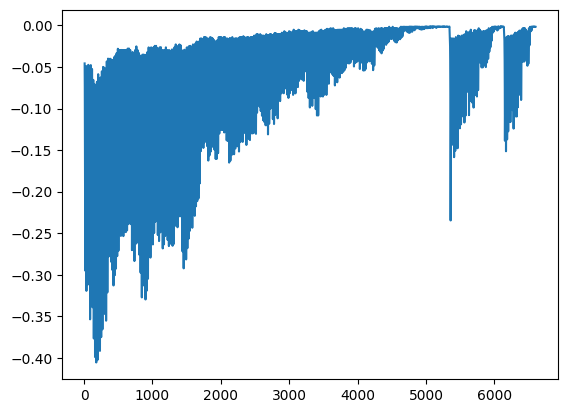

In [22]:
put_df = concatenated_df[(concatenated_df['Date'] == '2022-12-12') & (concatenated_df['Type'] == 'PE')]
put_df['delta_opt'].plot()

In [44]:
target_value = -0.3
target_value_2 = -0.05
date = '2022-12-12'
check_df = concatenated_df[(concatenated_df['Type'] == 'PE') & (concatenated_df['Date'].astype('str') == date)]
check_df['delta_difference'] = abs(check_df['delta_opt'] - target_value)
check_df['delta_difference_2'] = abs(check_df['delta_opt'] - target_value_2)
closest_entry_index = check_df['delta_difference'].idxmin()
closest_entry_index_2 = check_df['delta_difference_2'].idxmin()
closest_short_strike = check_df.loc[closest_entry_index].strike
closest_long_strike = check_df.loc[closest_entry_index_2].strike
closest_short_delta = check_df.loc[closest_entry_index].delta_opt
closest_long_delta = check_df.loc[closest_entry_index_2].delta_opt
o=check_df.loc[closest_entry_index].open_opt
h=check_df.loc[closest_entry_index].high_opt
l=check_df.loc[closest_entry_index].low_opt
c=check_df.loc[closest_entry_index].close_opt
check_df

C:\Users\HP\AppData\Local\Temp\ipykernel_8324\2684131641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df['delta_difference'] = abs(check_df['delta_opt'] - target_value)
C:\Users\HP\AppData\Local\Temp\ipykernel_8324\2684131641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df['delta_difference_2'] = abs(check_df['delta_opt'] - target_value_2)


,open_opt,high_opt,low_opt,close_opt,volume_opt,vwap_opt,timestamp_opt,transactions_opt,Datetime,strike,...,Time,delta_opt,open,high,low,close,Date,signal,delta_difference,delta_difference_2
9,1.75,1.96,1.20,1.35,338,1.6590,1670855400000,130,2022-12-12 09:30:00,3900,...,09:30:00,-0.045718,3939.29,3945.66,3939.29,3944.89,2022-12-12,0,0.254282,0.004282
10,2.35,2.55,1.59,1.65,110,2.0743,1670855400000,38,2022-12-12 09:30:00,3905,...,09:30:00,-0.056026,3939.29,3945.66,3939.29,3944.89,2022-12-12,0,0.243974,0.006026
11,3.05,3.40,2.10,2.19,158,2.7304,1670855400000,77,2022-12-12 09:30:00,3910,...,09:30:00,-0.073791,3939.29,3945.66,3939.29,3944.89,2022-12-12,0,0.226209,0.023791
12,3.86,4.10,2.92,2.92,57,3.5882,1670855400000,31,2022-12-12 09:30:00,3915,...,09:30:00,-0.097216,3939.29,3945.66,3939.29,3944.89,2022-12-12,0,0.202784,0.047216
13,4.92,4.96,3.55,3.80,82,4.4430,1670855400000,38,2022-12-12 09:30:00,3920,...,09:30:00,-0.124984,3939.29,3945.66,3939.29,3944.89,2022-12-12,0,0.175016,0.074984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587,0.05,0.05,0.05,0.05,3,0.0500,1670878680000,1,2022-12-12 15:58:00,3920,...,15:58:00,-0.001647,3988.97,3989.28,3988.14,3989.01,2022-12-12,0,0.298353,0.048353
6594,0.05,0.05,0.05,0.05,2,0.0500,1670878560000,2,2022-12-12 15:56:00,3900,...,15:56:00,-0.001705,3986.07,3988.84,3986.07,3988.84,2022-12-12,0,0.298295,0.048295
6595,0.05,0.05,0.05,0.05,5,0.0500,1670878560000,1,2022-12-12 15:56:00,3915,...,15:56:00,-0.001672,3986.07,3988.84,3986.07,3988.84,2022-12-12,0,0.298328,0.048328
6596,0.05,0.05,0.05,0.05,10,0.0500,1670878560000,6,2022-12-12 15:56:00,3940,...,15:56:00,-0.001415,3986.07,3988.84,3986.07,3988.84,2022-12-12,0,0.298585,0.048585


In [48]:
small = check_df.nsmallest(10, 'delta_opt')
small

,open_opt,high_opt,low_opt,close_opt,volume_opt,vwap_opt,timestamp_opt,transactions_opt,Datetime,strike,...,Time,delta_opt,open,high,low,close,Date,signal,delta_difference,delta_difference_2
179,13.70,14.00,13.2,13.60,150,13.7465,1670855940000,60,2022-12-12 09:39:00,3940,...,09:39:00,-0.405590,3936.45,3936.89,3935.30,3935.59,2022-12-12,0,0.105590,0.355590
197,13.65,13.90,12.3,13.70,144,13.1459,1670856000000,50,2022-12-12 09:40:00,3940,...,09:40:00,-0.402612,3935.50,3937.87,3935.50,3936.01,2022-12-12,0,0.102612,0.352612
161,13.00,13.90,12.4,13.80,248,13.0252,1670855880000,93,2022-12-12 09:38:00,3940,...,09:38:00,-0.399011,3938.44,3939.12,3936.42,3936.52,2022-12-12,0,0.099011,0.349011
233,12.31,13.30,12.2,13.20,66,12.8421,1670856120000,25,2022-12-12 09:42:00,3940,...,09:42:00,-0.391633,3938.38,3938.61,3936.24,3936.79,2022-12-12,0,0.091633,0.341633
143,11.40,12.90,11.4,12.90,282,12.1889,1670855820000,99,2022-12-12 09:37:00,3940,...,09:37:00,-0.376747,3941.19,3941.19,3938.30,3938.31,2022-12-12,0,0.076747,0.326747
251,13.23,13.70,12.4,12.52,62,12.8684,1670856180000,20,2022-12-12 09:43:00,3940,...,09:43:00,-0.375094,3936.84,3938.11,3936.17,3938.03,2022-12-12,0,0.075094,0.325094
215,12.55,13.11,12.2,12.53,66,12.7303,1670856060000,25,2022-12-12 09:41:00,3940,...,09:41:00,-0.373132,3936.08,3938.66,3936.08,3938.30,2022-12-12,0,0.073132,0.323132
269,12.50,12.60,11.8,12.10,190,12.4195,1670856240000,30,2022-12-12 09:44:00,3940,...,09:44:00,-0.365701,3938.17,3938.96,3937.92,3938.68,2022-12-12,0,0.065701,0.315701
323,11.24,12.20,11.2,11.60,245,11.9205,1670856420000,48,2022-12-12 09:47:00,3940,...,09:47:00,-0.355302,3940.10,3940.30,3938.87,3939.32,2022-12-12,0,0.055302,0.305302
89,10.60,12.30,10.6,11.90,265,11.8606,1670855640000,89,2022-12-12 09:34:00,3940,...,09:34:00,-0.353665,3944.07,3944.20,3939.83,3940.07,2022-12-12,0,0.053665,0.303665


In [45]:
closest_row = check_df.iloc[(df['delta_opt'] + 0.30).idxmin()]
closest_row

open_opt                             1.93
high_opt                             2.22
low_opt                               1.9
close_opt                            1.95
volume_opt                             89
vwap_opt                           2.0799
timestamp_opt               1670855520000
transactions_opt                       31
Datetime              2022-12-12 09:32:00
strike                               3905
expiry                             221212
Type                                   PE
open_spot                         3942.62
high_spot                         3943.97
low_spot                          3941.21
close_spot                        3943.48
RFR                                   3.8
Time                             09:32:00
delta_opt                       -0.065383
open                              3942.62
high                              3943.97
low                               3941.21
close                             3943.48
Date                  2022-12-12 0

In [32]:
date = '2022-12-12'
check_df = concatenated_df[(concatenated_df['Type'] == 'PE') & (concatenated_df['Date'].astype('str') == date)]
check_df
# check_df['delta_opt'].plot()

,open_opt,high_opt,low_opt,close_opt,volume_opt,vwap_opt,timestamp_opt,transactions_opt,Datetime,strike,...,close_spot,RFR,Time,delta_opt,open,high,low,close,Date,signal
9,1.75,1.96,1.20,1.35,338,1.6590,1670855400000,130,2022-12-12 09:30:00,3900,...,3944.89,3.8,09:30:00,-0.045718,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
10,2.35,2.55,1.59,1.65,110,2.0743,1670855400000,38,2022-12-12 09:30:00,3905,...,3944.89,3.8,09:30:00,-0.056026,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
11,3.05,3.40,2.10,2.19,158,2.7304,1670855400000,77,2022-12-12 09:30:00,3910,...,3944.89,3.8,09:30:00,-0.073791,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
12,3.86,4.10,2.92,2.92,57,3.5882,1670855400000,31,2022-12-12 09:30:00,3915,...,3944.89,3.8,09:30:00,-0.097216,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
13,4.92,4.96,3.55,3.80,82,4.4430,1670855400000,38,2022-12-12 09:30:00,3920,...,3944.89,3.8,09:30:00,-0.124984,3939.29,3945.66,3939.29,3944.89,2022-12-12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587,0.05,0.05,0.05,0.05,3,0.0500,1670878680000,1,2022-12-12 15:58:00,3920,...,3989.01,3.8,15:58:00,-0.001647,3988.97,3989.28,3988.14,3989.01,2022-12-12,0
6594,0.05,0.05,0.05,0.05,2,0.0500,1670878560000,2,2022-12-12 15:56:00,3900,...,3988.84,3.8,15:56:00,-0.001705,3986.07,3988.84,3986.07,3988.84,2022-12-12,0
6595,0.05,0.05,0.05,0.05,5,0.0500,1670878560000,1,2022-12-12 15:56:00,3915,...,3988.84,3.8,15:56:00,-0.001672,3986.07,3988.84,3986.07,3988.84,2022-12-12,0
6596,0.05,0.05,0.05,0.05,10,0.0500,1670878560000,6,2022-12-12 15:56:00,3940,...,3988.84,3.8,15:56:00,-0.001415,3986.07,3988.84,3986.07,3988.84,2022-12-12,0


In [36]:
top_10_smallest = check_df.nsmallest(10, 'delta_opt')

# Print or use the top 10 smallest values
print(top_10_smallest)

     open_opt  high_opt  low_opt  close_opt volume_opt  vwap_opt  \
179     13.70     14.00     13.2      13.60        150   13.7465   
197     13.65     13.90     12.3      13.70        144   13.1459   
161     13.00     13.90     12.4      13.80        248   13.0252   
233     12.31     13.30     12.2      13.20         66   12.8421   
143     11.40     12.90     11.4      12.90        282   12.1889   
251     13.23     13.70     12.4      12.52         62   12.8684   
215     12.55     13.11     12.2      12.53         66   12.7303   
269     12.50     12.60     11.8      12.10        190   12.4195   
323     11.24     12.20     11.2      11.60        245   11.9205   
89      10.60     12.30     10.6      11.90        265   11.8606   

     timestamp_opt transactions_opt            Datetime strike  ...  \
179  1670855940000               60 2022-12-12 09:39:00   3940  ...   
197  1670856000000               50 2022-12-12 09:40:00   3940  ...   
161  1670855880000               93 20

In [26]:
liz=[]
for x in concatenated_df[:5].Date.unique():
    dd=concatenated_df[concatenated_df['Date'] == x]
    print(dd)
    signal=dd.iloc[0].signal
    if signal==0:
        liz.append(short_put_leg_finder(-0.3,-0.05,str(x)))
    elif signal==1:
        liz.append(short_call_leg_finder(0.3,0.05,str(x)))
backtest=pd.DataFrame(liz,columns=['date' , 'closest_short_strike', 'closest_long_strike', 'closest_short_delta', 'closest_long_delta', 'o', 'h', 'l', 'c' , 'o_2', 'h_2', 'l_2', 'c_2' , 'o_u', 'h_u', 'l_u', 'c_u'])

      open_opt  high_opt  low_opt  close_opt volume_opt  vwap_opt  \
0        13.64     16.10    13.60      15.49         99   15.1737   
1        11.60     13.20    11.00      12.64         53   12.0542   
2         9.18     10.30     8.70      10.00        195    9.4916   
3         7.09      8.30     6.60       7.70         55    7.4829   
4         5.36      6.40     5.17       5.90         62    5.7989   
...        ...       ...      ...        ...        ...       ...   
6598     15.30     16.77    15.30      16.77         11   16.4691   
6599     10.40     11.76    10.40      11.30         25   11.1216   
6600      6.17      7.10     6.00       6.70        107    6.3489   
6601      2.55      3.10     2.15       2.80         95    2.6008   
6602      0.05      0.05     0.05       0.05          1    0.0500   

      timestamp_opt transactions_opt            Datetime strike  ...  \
0     1670855400000               48 2022-12-12 09:30:00   3940  ...   
1     1670855400000        

ValueError: attempt to get argmin of an empty sequence

In [25]:
liz

[]